# Katastrophenrettung - Simulation und Aufgaben

## Setup

In [37]:
# Setup
from schema import *
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Dict, Tuple, Any
import seaborn as sns
from copy import deepcopy
import pandas as pd
# import mesa.mesa_logging
# mesa.mesa_logging.log_to_stderr()

## Initialisierung der Simulation [Aufgaben 1, 3, 5]

Als Algorithmus für die Generierung des Labyrinths haben wir den **iterativen Ansatz des random DFS** gewählt, da die Struktur des erzeugten Labyrinths für die Simulation passend war.

Die Ausgänge des Labyrinths (**EXIT**) werden zufällig an den Rändern platziert. Sie dienen als Sicherheitszone, der sog. Savezone, an welchen die Überlebenden versorgt werden können.
Anschließend werden die Überlebenden (**SURV**) zufällig im Labyrinth platziert, wobei sie nicht an den Positionen der Savezones platziert werden dürfen.

Der Roboterhund (**AGENT**) wird an eine der Savezones per Zufall platziert, von wo aus er startet. Wir haben uns dagegen entschieden, den Roboterhund an einer zufälligen Position, unabhängig von den Savezones, im Labyrinth zu platzieren.
Das Ziel der Simulation ist es, alle Überlebenden in möglichst wenig benötigten Schritten und bewegten Feldern durch den Roboterhund in die Sicherheitszonen zu bringen, sodass sie versorgt werden können.

_Bitte beachten: In dieser Darstellung bedeuten die Kanten, dass zwischen zwei Punkten eine Verbindung existiert._

Survivor bei (7, 3)
Survivor bei (2, 5)
Survivor bei (4, 1)
Survivor bei (9, 2)
Survivor bei (7, 7)

Savezone bei (2, 9)
Savezone bei (6, 9)
Savezone bei (0, 0)
Savezone bei (5, 0)

Agent bei (2, 9)


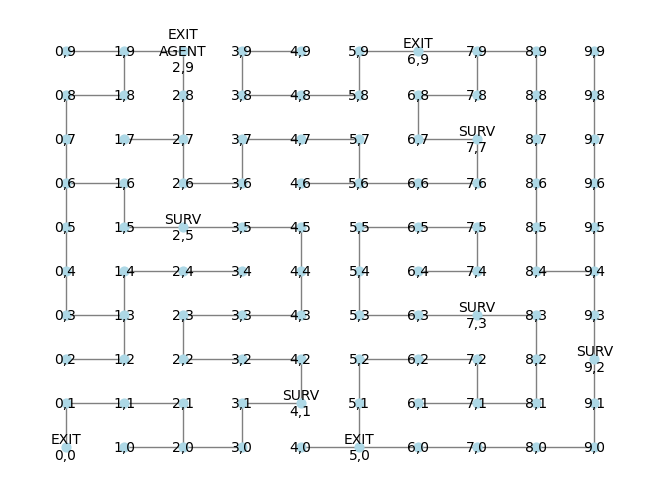

In [38]:
# Simulation parameters:
# Width and height of the environment
# Number of survivors, save zones and robots (agents)
environment = EnvironmentModel(
    width=10,
    height=10,
    n_survivors=5,
    n_save_zones=4, # must be >1 for task 4
    n_robot_agents=1, # must be 1 for task 4
    seed=42,
)

# unchanged environment for later runs (task 4) needed
initial_environment = deepcopy(environment)

# Printing object locations
for s in environment.survivors:
    print(f"Survivor bei ({s.tile.x}, {s.tile.y})")
print()
for sz in environment.save_zones:
    print(f"Savezone bei ({sz.tile.x}, {sz.tile.y})")
print()
for ra in environment.agents_by_type[RobotAgent]:
    print(f"Agent bei ({ra.tile.x}, {ra.tile.y})")
    
# Visualizing as a networkX graph
environment.visualize_graph()

## Metriken [Aufgabe 2]
### Pfadlänge
Als Pfadlänge wurde der Abstand zwischen den Savezones und den Überlebenden gewählt, da die Pfadlänge auf alle Punkte für das Lösen des Problems nicht von Bedeutung wäre.
Würde man die Pfadlänge zwischen allen Positionen im Labyrinth betrachten, so wäre die minimale Pfadlänge 1, sobald zwei Positionen eine direkte Verbindung haben - bei einem Labyrinth also immer.
Nach der im Seminar thematisierten "Kleine-Welt-Experiment" von Milgram (1967) ist zudem

Mittels **A-Star** wird die Pfadlänge zwischen jeder Savezone und jedem Überlebenden ermittelt. Anschließend werden die minimalen, maximalen und durchschnittlichen Werte ermittelt.


_Bei 4 Savezones und 5 Überlebenden werden somit 20 Pfadlängen generiert._

In [39]:
pathlengths: List[int] = environment.get_pathlengths_savezones_to_survivors()
min_pathlength: int = min(pathlengths)
max_pathlength: int = max(pathlengths)
mean_pathlength: float = sum(pathlengths) / len(pathlengths)

print("Die minimale Pfadlänge beträgt:", min_pathlength)
print("Die maximale Pfadlänge beträgt:", max_pathlength)
print("Die durchschnittliche Pfadlänge beträgt:", mean_pathlength)

Die minimale Pfadlänge beträgt: 5
Die maximale Pfadlänge beträgt: 64
Die durchschnittliche Pfadlänge beträgt: 24.55


### Dichte von Wänden

Zur Berechnung der Wände wurde mit einem Graphen gearbeitet.

Die Dichte ergibt sich aus der Anzahl der Kanten zwischen den Positionen des Labyrinths _durch_ die insgesamt möglichen Kanten zwischen den jeweiligen Positionen des Labyrinths.

_Beispiel:_
_Anzahl der Kanten: 20;_
_Anzahl möglicher Kanten bei einem 5x5 Maze: 40._

_Dichte: 20 / 40 = 0.50._

Die Dichte sagt somit aus, wie viel Prozent der möglichen Knoten zwischen den Positionen wirklich ausgeprägt sind.

In [40]:
mean_wall_density: float = environment.get_mean_wall_density()
print("Die durchschnittliche Wanddichte beträgt:", mean_wall_density)

Die durchschnittliche Wanddichte beträgt: 0.55


### Anzahl der Ausgänge

Durch unsere Datenstruktur lässt sich die Anzahl der Ausgänge einfach bestimmen.

Ausgänge aus dem Labyrinth existieren nur an den Stellen, wo die Savezones sind.
Wenn ein Überlebender an eine Savezone gelangt, wird er auch automatisch als _gerettet_ markiert und ist nicht mehr für die Simulation relevant.

In [41]:
exit_count: int = environment.get_exit_count()
print("Die Anzahl der Ausgänge beträgt:", exit_count)

Die Anzahl der Ausgänge beträgt: 4


### Symmetrien

Symmetrien fest als vorhanden oder nicht vorhanden zu klassifizieren ist in der Betrachtung eines Labyrinths nicht zielführend, da die Wahrscheinlichkeit für das Auftreten einer reinen Symmetrie bei Labyrinthen mit annehmbarer Größe (z.B. 10x10) zu klein wäre.

Stattdessen berechnen wir den **Grad der vertikalen und horizontalen Symmetrie in Prozent**.

Beispiel: Die horizontale Symmetrie wird ermittelt, indem man das Labyrinth vertikal in der Mitte _durchschneidet_. (Offensichtlich gilt bei Labyrinthen mit ungerader Breite, dass die mittlere Spalte ignoriert werden kann.)
Nun wird für jedes gegenüberliegende Kästchenpärchen verglichen, wie viele Wände spiegelverkehrt übereinstimmen.
Bei einer 25-prozentigen horizontalen Symmetrie stimmen somit 1/4 der Wände überein.

In [42]:
horizontal_symmetry: float  = environment.check_horizontal_symmetry()
vertical_symmetry: float = environment.check_vertical_symmetry()

print("Der Grad der horizontalen Symmetrie beträgt:", horizontal_symmetry)
print("Der Grad der vertikalen Symmetrie beträgt:", vertical_symmetry) # TODO correct?

Der Grad der horizontalen Symmetrie beträgt: 0
Der Grad der vertikalen Symmetrie beträgt: 0


## Analyse der Schritte [Aufgaben 4, 5]
### Simulation

Für die Simulation wird die **Bibliothek Mesa** verwendet. Das hat den Vorteil, dass die Umgebung (mesa.Model) schrittweise durch Schritte verändert werden kann.
In jeden **Simulationsschritt** (Step) führen die Agenten eine Aktion aus. Dadurch wird der Zustand der Umgebung verändert.

Folgende Schritte sind für die Agenten möglich:

- Aufnehmen eines Überlebenden (wenn sich der Agent an der Position des Überlebenden befindet und bereits keinen Überlebenden trägt)
- Herablassen eines Überlebenden (wenn der Agent einen Überlebenden transportiert) 
- Bewegen zu einem Überlebenden 
- Bewegen zu einer SaveZone

Beim Aufnehmen und Herablassen der Überlebenden werden nur noch nicht gerettete berücksichtigt.
Beim Bewegen wird der **A-Star** Algorithmus zur Pfadfindung verwendet. Dieser beachtet die bisherigen Pfadkosten g(n) und die Heuristik-Funktion h(n). 

Als Heuristik wird die **Manhattan-Distanz** verwendet. Wegen der auf horizontale und vertikale Schritte begrenzten Bewegung im Labyrinth, bzw. Grid, liefert die Manhattan-Distanz eine realistischere und oftmals genauere Unterschätzung der tatsächlichen Pfadlänge (bei nicht-diagonalen Bewegungen), was ein wichtiges Kriterium für den A-Stern Algorithmus ist. 

Der euklidische Algorithmus kann die Pfadlänge zu sehr unterschätzen, da diagonale Bewegungen mit einbezogen werden könnten. Zudem würden mathematische Wurzeloperationen verwendet werden, weshalb der euklidische Algorithmus also rechenintensiver wäre als die Manhattan-Distanz.

Die Umgebung wird nach jeder Aktion der Agenten aktualisiert, da sich bei mehr als einem Agenten die Roboter gegenseitig negativ beeinträchtigen könnten. Die Roboter agieren deshalb innerhalb eines Simulationsschrittes nacheinander, die Reihenfolge ist dabei nicht zufällig.

Im Folgenden wird ein einzelner Simulationsschritt dargestellt.

--- Step: 1 ---
Agent 1 not transporting survivor. Moved to next survivor. (2, 5)
Bewegte Felder des Agenten: 8


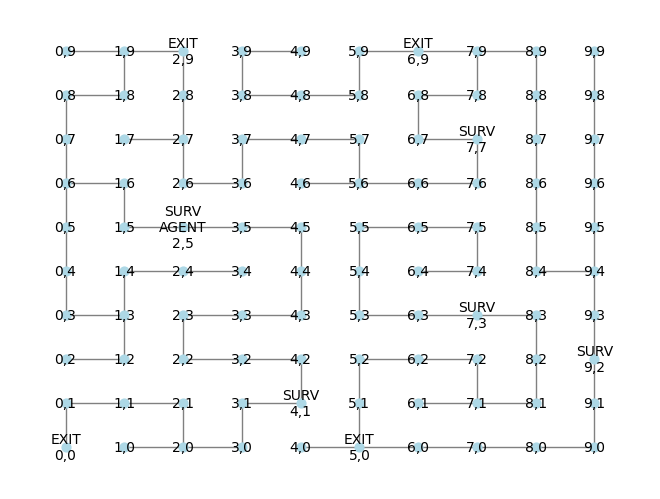

In [43]:
environment.step()
print("Bewegte Felder des Agenten:", environment.agents_by_type[RobotAgent][0].tiles_moved)
environment.visualize_graph()

Der Agent 1 trägt zu Beginn keinen Überlebenden und befindet sich an einer der SaveZones.
Da es Überlebende gibt, die noch nicht gerettet wurden, sucht der Agent 1 mittels des A-Stern Algorithmus den nächsten Überlebenden.

Er findet den nächsten Überlebenden und bewegt sich zu diesem; dabei werden die benötigten Felder mitgezählt und in der Konsole ausgegeben.

In [44]:
environment.step()

--- Step: 2 ---
Agent 1 picked up survivor at (2, 5)


Der Agent 1 nimmt den Überlebenden an der selben Position auf. Nun soll der Überlebende an der nächsten SaveZone abgesetzt werden.

--- Step: 3 ---
Agent 1 transporting survivor. Moved to save zone. (2, 9)
Bewegte Felder des Agenten: 16


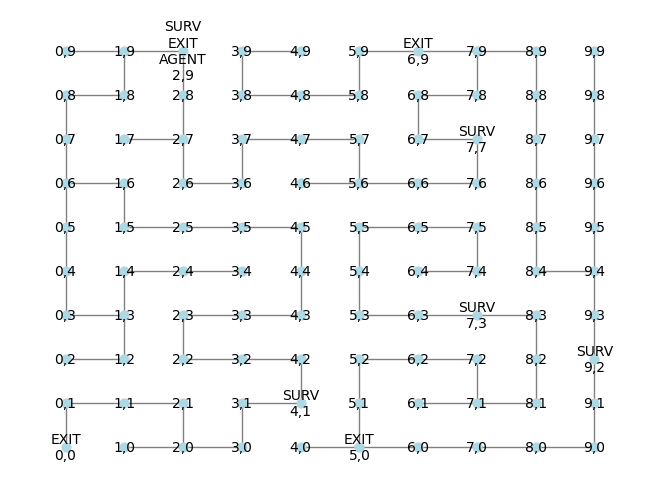

In [45]:
environment.step()
print("Bewegte Felder des Agenten:", environment.agents_by_type[RobotAgent][0].tiles_moved)
environment.visualize_graph()

Der Agent 1 setzt den Überlebenden an der nächsten SaveZone ab. Von dort aus beginnt der Zyklus von vorne, bis alle Überlebenden gerettet wurden.

Die Simulation wird nun automatisch bis zur Endbedingung (alle Überlebenden gerettet) fortgesetzt.

In [46]:
environment.run_model()

--- Step: 4 ---
Agent 1 placed down survivor at (2, 9)
--- Step: 5 ---
Agent 1 not transporting survivor. Moved to next survivor. (7, 7)
--- Step: 6 ---
Agent 1 picked up survivor at (7, 7)
--- Step: 7 ---
Agent 1 transporting survivor. Moved to save zone. (6, 9)
--- Step: 8 ---
Agent 1 placed down survivor at (6, 9)
--- Step: 9 ---
Agent 1 not transporting survivor. Moved to next survivor. (9, 2)
--- Step: 10 ---
Agent 1 picked up survivor at (9, 2)
--- Step: 11 ---
Agent 1 transporting survivor. Moved to save zone. (5, 0)
--- Step: 12 ---
Agent 1 placed down survivor at (5, 0)
--- Step: 13 ---
Agent 1 not transporting survivor. Moved to next survivor. (7, 3)
--- Step: 14 ---
Agent 1 picked up survivor at (7, 3)
--- Step: 15 ---
Agent 1 transporting survivor. Moved to save zone. (5, 0)
--- Step: 16 ---
Agent 1 placed down survivor at (5, 0)
--- Step: 17 ---
Agent 1 not transporting survivor. Moved to next survivor. (4, 1)
--- Step: 18 ---
Agent 1 picked up survivor at (4, 1)
--- Step:

Die Simulation wurde nach dem 20. Schritt beendet, da alle Überlebenden gerettet wurden.

Bei jedem Simulationsschritt werden Metriken zu Agenten und der Umgebung per mesa.data_collector gesammelt. Dies ist für den batch-run später wichtig.

### Wahl der Save-Felder für die Überlebenden

Nach dem Durchlaufen der Simulation bis zur Endbedingung wurden die Überlebenden zu ihren optimalen SaveZones gebracht.
In der Visualisierung ist das zu erkennen:
An den SaveZones (EXIT) sind Überlebende (SURV) abgesetzt. Die Position des Roboters (AGENT) ist die des zuletzt geretteten Überlebenden.

Uns fiel in den Simulationen auf, dass isolierte SaveZones (*) oft eine Großzahl an Überlebenden beherbergen. Mit genug Simulationsdaten wäre diese Annahme interessant, zu überprüfen. Dafür müssten die Pfadlängen zwischen den SaveZones selbst und die am Ende beherbergten Überlebenden gesammelt und analysiert werden. 

_(*) Isolierte SaveZones sind SaveZones, die eine hohe Pfadlänge zu allen anderen SaveZones haben. Nach dieser Definition müsste es stets eine SaveZone geben, am isoliertesten von anderen SaveZone ist._

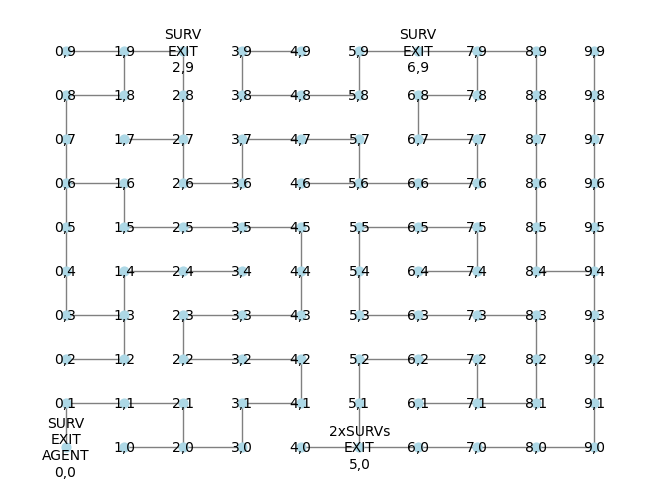

In [47]:
environment.visualize_graph()

### Optimale Startposition

Für die optimale Startposition kann die Simulation für jede Startposition durchgeführt und anschließend ausgewertet werden.
Voraussetzung dafür ist, dass nur ein Roboter für die Simulation verwendet wird.

In [48]:
# use initial_environment as a deepcopy from the environment from before
runs: List[Dict] = []

for iteration in range(len(initial_environment.save_zones)):
    tmp_environment: EnvironmentModel = deepcopy(initial_environment)
    if len(tmp_environment._agents_by_type[RobotAgent]) > 1:
        print("Zu viele Roboter für diese Aufgabe, bitte nur 1 Roboter verwenden.")
        break

    # Override the start-savezone of the robot agent
    start_save_zone: SaveZone = tmp_environment.save_zones[iteration]
    tmp_environment._agents_by_type[RobotAgent][0].tile = start_save_zone.tile

    # gather data
    print(f"\nIteration: {iteration}. Start SaveZone: ({start_save_zone.tile.x},{start_save_zone.tile.y})")
    tmp_environment.run_model();
    runs.append(
        {
            "iteration": iteration,
            "start_save_zone": start_save_zone.tile,
            "steps": tmp_environment.steps,
            "tiles_moved": tmp_environment._agents_by_type[RobotAgent][0].tiles_moved,
        }
    );


Iteration: 0. Start SaveZone: (2,9)
--- Step: 1 ---
Agent 1 not transporting survivor. Moved to next survivor. (2, 5)
--- Step: 2 ---
Agent 1 picked up survivor at (2, 5)
--- Step: 3 ---
Agent 1 transporting survivor. Moved to save zone. (2, 9)
--- Step: 4 ---
Agent 1 placed down survivor at (2, 9)
--- Step: 5 ---
Agent 1 not transporting survivor. Moved to next survivor. (7, 7)
--- Step: 6 ---
Agent 1 picked up survivor at (7, 7)
--- Step: 7 ---
Agent 1 transporting survivor. Moved to save zone. (6, 9)
--- Step: 8 ---
Agent 1 placed down survivor at (6, 9)
--- Step: 9 ---
Agent 1 not transporting survivor. Moved to next survivor. (9, 2)
--- Step: 10 ---
Agent 1 picked up survivor at (9, 2)
--- Step: 11 ---
Agent 1 transporting survivor. Moved to save zone. (5, 0)
--- Step: 12 ---
Agent 1 placed down survivor at (5, 0)
--- Step: 13 ---
Agent 1 not transporting survivor. Moved to next survivor. (7, 3)
--- Step: 14 ---
Agent 1 picked up survivor at (7, 3)
--- Step: 15 ---
Agent 1 transp

In [49]:
# Analysis of the iteration results:
for run in runs:
    print(f"Start SaveZone: ({run['start_save_zone'].x},{run['start_save_zone'].y})")
    print(f" - Benötigte Steps (Schritte): {run['steps']}")
    print(
        f" - Benötigte Felder (Tiles): {run['tiles_moved']}"
    )

# best run:
best_run: Dict = min(runs, key=lambda r: r["tiles_moved"])
print(f"\nBestes Ergebnis nach bewegten Feldern: {best_run['steps']} Schritte, {best_run['tiles_moved']} Felder (Tiles)"
    + f" für Start-SaveZone ({best_run['start_save_zone'].x},{best_run['start_save_zone'].y})")

# Prozentuale Unterschied bester vs schlechtester tiles moved
worst_run: Dict = max(runs, key=lambda r: r["tiles_moved"])
percentage_difference: float = (
    (worst_run["tiles_moved"] - best_run["tiles_moved"]) / worst_run["tiles_moved"]
) * 100

print(f"Der schlechteste Run ist {round(percentage_difference, 2)}% "+ 
    f"({worst_run['tiles_moved'] - best_run['tiles_moved']} Felder) schlechter als der beste Run.")

# Standard deviation of tiles_moved
std_dev: float = pd.Series([run["tiles_moved"] for run in runs]).std()
print(f"Standardabweichung der bewegten Felder (Tiles): {round(std_dev, 2)}")

Start SaveZone: (2,9)
 - Benötigte Steps (Schritte): 21
 - Benötigte Felder (Tiles): 121
Start SaveZone: (6,9)
 - Benötigte Steps (Schritte): 21
 - Benötigte Felder (Tiles): 115
Start SaveZone: (0,0)
 - Benötigte Steps (Schritte): 21
 - Benötigte Felder (Tiles): 89
Start SaveZone: (5,0)
 - Benötigte Steps (Schritte): 21
 - Benötigte Felder (Tiles): 111

Bestes Ergebnis nach bewegten Feldern: 21 Schritte, 89 Felder (Tiles) für Start-SaveZone (0,0)
Der schlechteste Run ist 26.45% (32 Felder) schlechter als der beste Run.
Standardabweichung der bewegten Felder (Tiles): 13.95


Die Auswertung der optimalen Startposition zeigt folgende Ergebnisse:

- Die benötigten Simulationsschritte sind bei allen Simulationen gleich. Es gibt bisher keine Begrenzung der gelaufenen Felder pro Simulationsschritt für den Agenten.
- Selbst naheliegende Savezones können erheblichen Einfluss auf die gelaufenen Felder der Agenten haben, da eine leichte Wegänderung zu anderen gefundenen Pfaden und somit zu gänzlich anderen Durchläufen führen kann.
- Die Standardabweichung der gelaufenen Felder ist oft nur ein paar Felder groß, bei Werten zwischen 50 und 200.
- Die prozentuale Abweichung zwischen bestem und schlechtestem Run ist meist um die 10%.

Daraus lässt sich schließen, dass die Wahl der Startposition für den Agenten einen großen Einfluss auf die benötigten Schritte der Simulation hat.
In dem Szenario einer Katastophenrettung hat eine solche Wahl erheblichen Einfluss auf die benötigte Zeit, die letztendlich erheblich für das Überleben der Vermissten ist.

Nicht untersucht wurde hierbei der Einfluss der Anzahl der Agenten auf die benötigte Zeit.

## Eigene Erweiterung des Systems [Aufgabe 6]

Als Erweiterung des Systems rund um die Simulation wählten wir eine erweiterte Auswertung des Systems.
Dafür nutzten wir die von Mesa bereitgestellten **batch-run** Möglichkeiten, mit welchen die Simulationen sehr oft und effizient ausgeführt werden konnten.
Anschließend wurden die generierten Daten mit **Pandas** in passende Formate umgewandelt und mit **Seaborn** (auf Matplotlib aufbauend) visualisiert.

Hierbei verweisen wir auf die **Datei batch_run.ipynb**, in der die batch-run Simulationen und Analysen durchgeführt wurden.

## Anhang: Datensammlung

Mit Mesa konnten wir die Daten pro Simulationsschritt sammeln. Hier folgt eine kurze Übersicht der gesammelten Daten:

In [50]:
model_data = environment.datacollector.get_model_vars_dataframe()
agent_data = environment.datacollector.get_agent_vars_dataframe()

In [51]:
print("Model data:")
model_data.info()

Model data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Survivors                 21 non-null     object 
 1   SaveZones                 21 non-null     object 
 2   MazeWidth                 21 non-null     int64  
 3   MazeHeight                21 non-null     int64  
 4   AllSurvivorsRescued       21 non-null     bool   
 5   InitialPathlengths        21 non-null     object 
 6   MeanWallDensity           21 non-null     float64
 7   HorizontalSymmetry        21 non-null     int64  
 8   VeticalSymmetry           21 non-null     int64  
 9   ExitCount                 21 non-null     int64  
 10  TotalTilesMoved           21 non-null     int64  
 11  TotalSurvivorsPickedUp    21 non-null     int64  
 12  TotalSurvivorsPlacedDown  21 non-null     int64  
dtypes: bool(1), float64(1), int64(8), object(3)
memory usag

In [52]:
model_data.head(2)

,Survivors,SaveZones,MazeWidth,MazeHeight,AllSurvivorsRescued,InitialPathlengths,MeanWallDensity,HorizontalSymmetry,VeticalSymmetry,ExitCount,TotalTilesMoved,TotalSurvivorsPickedUp,TotalSurvivorsPlacedDown
0,[<schema.Survivor object at 0x000001CCB9D02330...,[<schema.SaveZone object at 0x000001CCB9603FC0...,10,10,False,"[39, 8, 18, 24, 11, 25, 24, 34, 10, 5, 64, 17,...",0.55,0,0,4,0,0,0
1,[<schema.Survivor object at 0x000001CCB9D01B50...,[<schema.SaveZone object at 0x000001CCB7538780...,10,10,False,"[39, 8, 18, 24, 11, 25, 24, 34, 10, 5, 64, 17,...",0.55,0,0,4,0,0,0


In [53]:
print("Agent data:")
agent_data.info()

Agent data:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21 entries, (np.int64(0), np.int64(1)) to (np.int64(20), np.int64(1))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Tile                 21 non-null     object
 1   TransportedSurvivor  10 non-null     object
 2   TilesMoved           21 non-null     int64 
 3   SurvivorsPickedUp    21 non-null     int64 
 4   SurvivorsPlacedDown  21 non-null     int64 
 5   StillRunning         21 non-null     bool  
dtypes: bool(1), int64(3), object(2)
memory usage: 1.8+ KB


In [54]:
agent_data.head(2)

,,Tile,TransportedSurvivor,TilesMoved,SurvivorsPickedUp,SurvivorsPlacedDown,StillRunning
Step,AgentID,,,,,,
0,1,<schema.Tile object at 0x000001CCB9CF80B0>,None,0,0,0,True
1,1,<schema.Tile object at 0x000001CCB98FFD70>,None,8,0,0,True
